In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.inspection import permutation_importance

In [13]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns

Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [14]:
df_copied = df.copy()

### Train Test Split

In [16]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School','num_lte_5ppb','County'])
y = df_copied['target_col']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)

In [17]:
X.columns

Index(['School_District', 'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races',
       'percent_housing_pre_1950'],
      dtype='object')

In [18]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

### Pipeline

In [19]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

### Validation

In [20]:
# Best parameters from hyperparameter tuning
# {'classifier__C': np.float64(2.402056248835655), 'classifier__penalty': 'l2'}

C = np.float64(2.402056248835655)
penalty = 'l2'

In [21]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C = C, penalty = penalty, max_iter=5000, solver='saga'))
])

In [22]:
roc_curves = []
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_curves.append((fpr, tpr))

print(roc_auc_score(y_test, y_pred))

0.7278348821928096


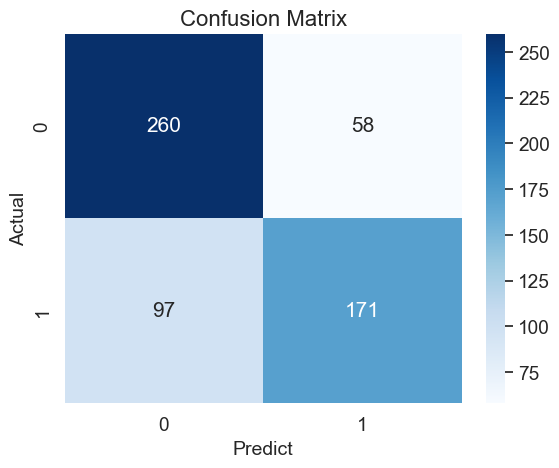

In [23]:
cm = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.25)
sns.heatmap(cm,annot=True, fmt='g',cmap='Blues')
plt.xlabel('Predict', fontsize='14')
plt.ylabel('Actual',fontsize='14')
plt.title('Confusion Matrix',fontsize='16')
plt.savefig('final_model_cm.png')
plt.show()

### Feature Importance

In [33]:
# t ransform X_test with the pipeline preprocessor
X_test_transformed = clf.named_steps['preprocessor'].transform(X_test)

# check if sparse
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# run permutation importance on Log Reg classifier only
perm_importance = permutation_importance(
    clf.named_steps['classifier'], 
    X_test_transformed,
    y_test,
    n_repeats=30,
    random_state=40,
    n_jobs=-1,
    scoring='roc_auc'
)

# get feature names from preprocessor
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

# output permutation importances
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean * 100,
    'importance_std': perm_importance.importances_std * 100
}).sort_values(by='importance_mean', ascending=False)

perm_df.head(10)


,feature,importance_mean,importance_std
194,cat__School_District_nyc_doe,4.637074,0.968381
6,num__White,1.763021,0.800263
5,num__Hispanic,1.555411,0.491835
686,cat__School_City_staten_island,1.388732,0.316743
354,cat__School_City_brooklyn,1.326661,0.445071
3,num__Asian,0.783563,0.298055
9,num__percent_housing_pre_1950,0.523170,0.373629
0,num__Ratio_free,0.380742,0.263142
310,cat__School_District_west_islip_union_free_school,0.349237,0.181193
729,cat__School_City_west_islip,0.349237,0.181193


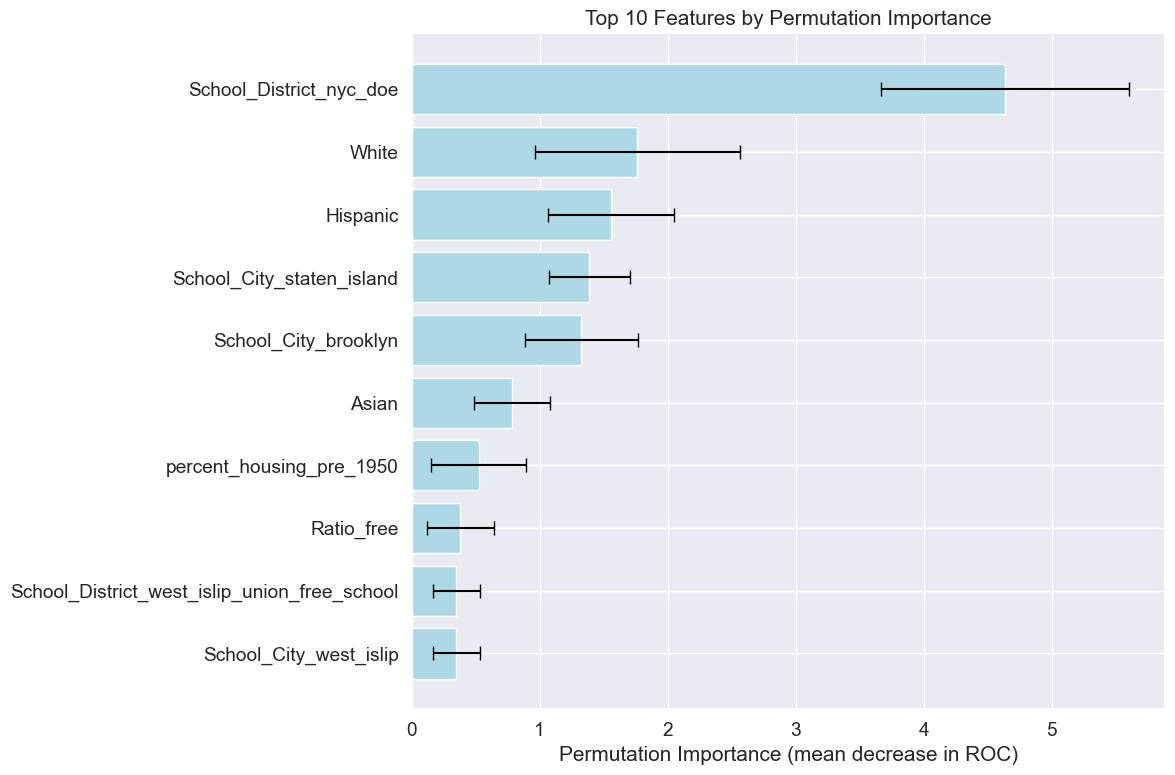

In [35]:
top_perm_df = perm_df.head(10).copy()
top_perm_df['clean_feature'] = top_perm_df['feature'].str.replace(r'^(cat__|num__)', '', regex=True)

plt.figure(figsize=(12,8))
plt.barh(top_perm_df['clean_feature'][::-1], top_perm_df['importance_mean'][::-1], 
         xerr=top_perm_df['importance_std'][::-1], color='lightblue', ecolor='black',capsize=5)
plt.xlabel('Permutation Importance (mean decrease in ROC)')
plt.title('Top 10 Features by Permutation Importance')
plt.tight_layout()
plt.savefig('final_modelpermutation_importance.png')
plt.show()